10 Animals Classification using MobileNetV2

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,RandomFlip,RandomRotation,RandomZoom,BatchNormalization,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Rescaling,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2

In [4]:
full_data = "/home/sonuts/10 animals detects/archive (1)/raw-img"

In [5]:
os.listdir(full_data)

['elefante',
 'pecora',
 'gallina',
 'mucca',
 'farfalla',
 'cane',
 'ragno',
 'scoiattolo',
 'gatto',
 'cavallo']

(423, 640, 3)


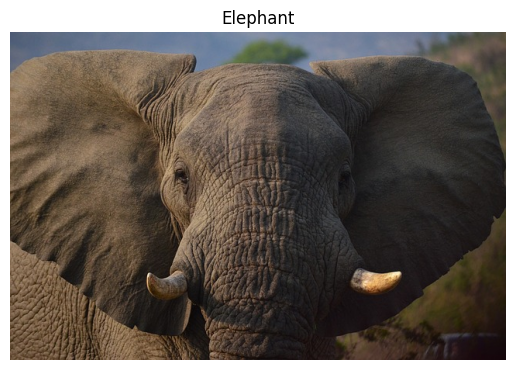

In [6]:
sample_img = Image.open("/home/sonuts/10 animals detects/archive (1)/raw-img/elefante/e83db70f21fc033ed1584d05fb1d4e9fe777ead218ac104497f5c978a4efbcb0_640.jpg")
sample_img = sample_img.convert("RGB")
sample_img = np.array(sample_img)
print(sample_img.shape)
plt.imshow(sample_img)
plt.title("Elephant")
plt.axis("off")
plt.show()

In [7]:
for classes in os.listdir(full_data):
    path = os.path.join(full_data, classes)
    print(classes, len(os.listdir(path)), "images")

elefante 1446 images
pecora 1820 images
gallina 3098 images
mucca 1866 images
farfalla 2112 images
cane 4863 images
ragno 4821 images
scoiattolo 1862 images
gatto 1668 images
cavallo 2623 images


In [8]:
# Removing Bad files

def clean_data(dir):
    bad_files = 0

    for classes in os.listdir(dir):
        classes_path = os.path.join(dir, classes)
        if not os.path.isdir(classes_path):
            continue

        for files in os.listdir(classes_path):
            files_path = os.path.join(classes_path, files)
            try:
                raw = tf.io.read_file(files_path)
                tf.image.decode_image(raw)
            except:
                os.remove(files_path)
                bad_files += 1

    print("Total Bad files removed: ", bad_files)


clean_data(full_data)

I0000 00:00:1762671512.420005    5744 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Total Bad files removed:  0


In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    full_data,
    seed = 36,
    image_size = (224,224),
    shuffle = True,
    batch_size = 32,
    validation_split = 0.2,
    subset = "training"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    full_data,
    seed = 36,
    image_size = (224,224),
    shuffle = True,
    batch_size = 32,
    validation_split = 0.2,
    subset = "validation"
)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [10]:
train_ds_class = train_ds.class_names
test_ds_class = test_ds.class_names

print(train_ds_class)
print(test_ds_class)

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [11]:
train_ds_class_dic = {}

for n,c in enumerate(train_ds_class):
    train_ds_class_dic.update({n: c})


In [12]:
train_ds_class_dic

{0: 'cane',
 1: 'cavallo',
 2: 'elefante',
 3: 'farfalla',
 4: 'gallina',
 5: 'gatto',
 6: 'mucca',
 7: 'pecora',
 8: 'ragno',
 9: 'scoiattolo'}

In [13]:
test_ds_class_dic = {}
for n,c in enumerate(test_ds_class):
    test_ds_class_dic.update({n:c})

In [14]:
test_ds_class_dic

{0: 'cane',
 1: 'cavallo',
 2: 'elefante',
 3: 'farfalla',
 4: 'gallina',
 5: 'gatto',
 6: 'mucca',
 7: 'pecora',
 8: 'ragno',
 9: 'scoiattolo'}

In [15]:
for images,labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)

(32, 224, 224, 3)
(32,)


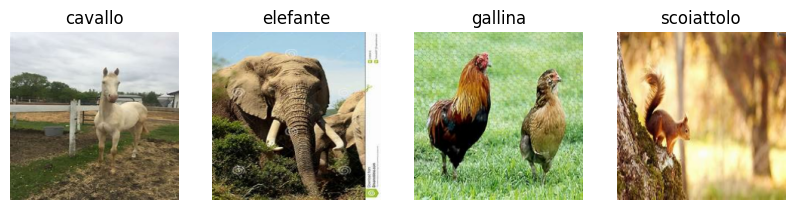

In [16]:
n = 4
plt.figure(figsize = (10,4))

for images,labels in train_ds.take(1):
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds_class_dic[labels[i].numpy()])
        plt.axis("off")

plt.show()



In [17]:
base_model = MobileNetV2(weights = "imagenet", include_top = False, input_shape = (224,224,3))
base_model.trainable = False


model = Sequential()

model.add(Input(shape = (224,224,3)))
model.add(Rescaling(1./255))
model.add(RandomFlip("horizontal"))
model.add(RandomRotation((0.04)))
model.add(RandomZoom((-0.1,0.1)))

model.add(base_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(10, activation = "softmax"))

model.compile(loss = "sparse_categorical_crossentropy", metrics = ["accuracy"], optimizer = Adam())
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,754 (9.25 MB)

 Trainable params: 165,514 (646.54 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [18]:
model_cb = EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)
model_training_info = model.fit(train_ds, epochs = 50, validation_data = test_ds, callbacks = model_cb)

Epoch 1/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 55s 75ms/step - accuracy: 0.8922 - loss: 0.3547 - val_accuracy: 0.9500 - val_loss: 0.1722
Epoch 2/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 49s 74ms/step - accuracy: 0.9333 - loss: 0.2189 - val_accuracy: 0.9522 - val_loss: 0.1648
Epoch 3/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9381 - loss: 0.1964 - val_accuracy: 0.9568 - val_loss: 0.1566
Epoch 4/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.9384 - loss: 0.1913 - val_accuracy: 0.9574 - val_loss: 0.1527
Epoch 5/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.9452 - loss: 0.1722 - val_accuracy: 0.9557 - val_loss: 0.1577
Epoch 6/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9474 - loss: 0.1688 - val_accuracy: 0.9538 - val_loss: 0.1683
Epoch 7/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.9479 - loss: 0.1644 - val_accuracy: 0.9534 - val_loss: 0.1652
Epoch 8/50
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9497 - loss: 0.1541 - 

In [19]:
model_history = model_training_info.history

In [20]:
model_history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

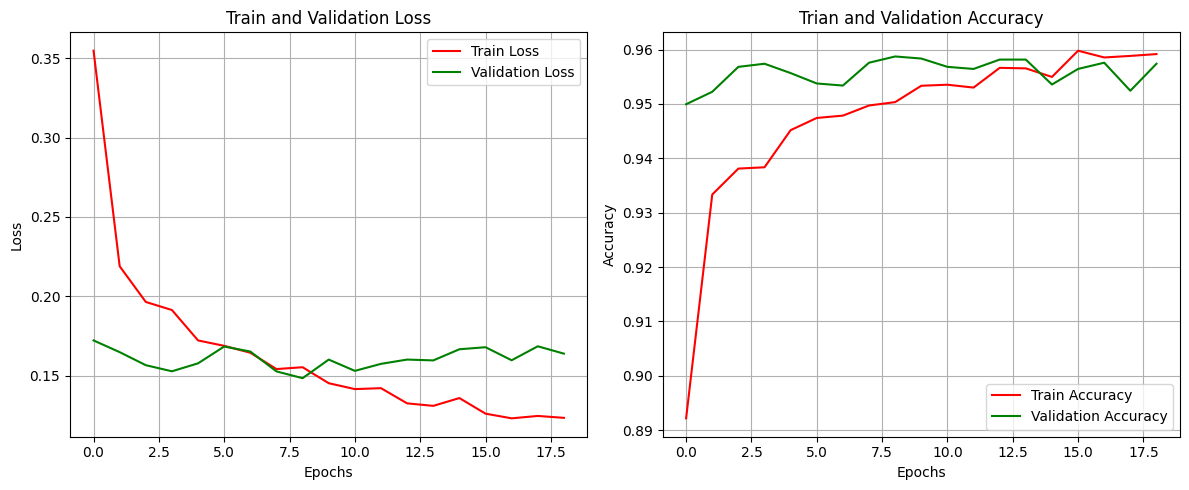

In [21]:
plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.plot(model_history["loss"], color = "red", label = "Train Loss")
plt.plot(model_history["val_loss"], color = "green", label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.title("Trian and Validation Accuracy")
plt.plot(model_history["accuracy"], color = "red", label = "Train Accuracy")
plt.plot(model_history["val_accuracy"], color = "green", label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()



In [22]:
print(model.evaluate(train_ds))

655/655 ━━━━━━━━━━━━━━━━━━━━ 35s 53ms/step - accuracy: 0.9756 - loss: 0.0784
[0.07842455059289932, 0.9756016135215759]


In [67]:
print(model.evaluate(test_ds))

164/164 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.9587 - loss: 0.1484
[0.14838698506355286, 0.9587392807006836]


In [27]:
model.save("/home/sonuts/10 animals detects/best_model.keras")
model.save_weights("/home/sonuts/10 animals detects/best_model.weights.h5")